<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/script_pytorch/Pix2pix_Edge2RGB_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pix2pix - edge > RGB

元論文 : Image-to-Image Translation with Conditional Adversarial Networks https://arxiv.org/abs/1611.07004 (2016)

pix2pixは画素（pixel)と画素の関係を学習させる。


In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [12]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from torchsummary import summary

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/pytorch/')
from _main_base_generative import *
#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = OrderedDict({
    'background' : [0, 0, 0],
    'akahara' : [128, 0, 0],
    'madara' : [0, 128, 0]
      }) # list, dict('label' : '[R, G, B]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_HEIGHT = 64
cfg.INPUT_WIDTH = 64
cfg.INPUT_CHANNEL = 1
cfg.INPUT_MODE = 'EDGE'
cfg.INPUT_CMAP = 'gray'

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = None # pyplot cmap

cfg.G_DIM = 32
cfg.D_DIM = 32

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'pix2pix'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 8
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}


cfg.TRAIN.DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# pix2pix  config
#---
cfg.PIX2PIX_LAMBDA = 1


# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.MAX_SAMPLES = 100
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': {'akahara': [128, 0, 0],
                 'background': [0, 0, 0],
                 'madara': [0, 128, 0]},
 'CLASS_NUM': 3,
 'DEVICE': device(type='cuda'),
 'DEVICE_TYPE': 'cuda',
 'D_DIM': 32,
 'GPU': True,
 'G_DIM': 32,
 'INPUT_CHANNEL': 1,
 'INPUT_CMAP': 'gray',
 'INPUT_HEIGHT': 64,
 'INPUT_MODE': 'EDGE',
 'INPUT_WIDTH': 64,
 'OUTPUT_CHANNEL': 3,
 'OUTPUT_CMAP': None,
 'OUTPUT_HEIGHT': 64,
 'OUTPUT_MODE': 'RGB',
 'OUTPUT_WIDTH': 64,
 'PIX2PIX_LAMBDA': 1,
 'PREFIX': 'pix2pix',
 'TEST': {'DATA_PATH': '/content/drive/My Drive/Colab '
                       'Notebooks/Dataset/test/images/',
          'ITERATION': 2,
          'MAX_SAMPLES': 100,
          'MINIBATCH': 10,
          'MODEL_G_PATH': 'models/pix2pix_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/pix2pix_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': True,
           'DATA_PATH': '/content/drive/My Drive/Colab '
                        'Notebooks

## Define Model

In [0]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.reshape(x.size()[0], -1)
        return x
    
class Encoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name, stack_num=2):
        super(Encoder_block, self).__init__()
        _module = OrderedDict()
        for i in range(stack_num):
            f = dim1 if i == 0 else dim2
            _module['{}_stack_{}_conv'.format(name, i  + 1)] = torch.nn.Conv2d(f, dim2, kernel_size=3, padding=1, stride=1)
            _module['{}_stack_{}_act'.format(name, i + 1)] = torch.nn.ReLU()
            _module['{}_stack_{}_bn'.format(name, i + 1)] = torch.nn.BatchNorm2d(dim2)
            
        self.module = torch.nn.Sequential(_module)

    def forward(self, x):
        return self.module(x)

class Decoder_block(torch.nn.Module):
    def __init__(self, dim1, dim2, name):
        super(Decoder_block, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            '{}_transConv'.format(name) : torch.nn.ConvTranspose2d(dim1, dim2, kernel_size=2, stride=2),
            '{}_bn'.format(name) : torch.nn.BatchNorm2d(dim2)
        }))

    def forward(self, x):
        return self.module(x)

    
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        dim = cfg.G_DIM
        
        self.encoders = torch.nn.ModuleList([
            Encoder_block(cfg.INPUT_CHANNEL, dim, name='G_encoder_1'), 
            Encoder_block(dim, dim * 2, name='G_encoder_2'),
            Encoder_block(dim * 2, dim * 4, name='G_encoder_3'),
            Encoder_block(dim * 4, dim * 8, name='G_encoder_4'),
            Encoder_block(dim * 8, dim * 16, name='G_encoder_5'),
            #Encoder_block(dim * 16, dim * 16, name='G_encoder_6'),
        ])
        
        self.decoders = torch.nn.ModuleList([
            #Encoder_block(dim * 16, dim * 16, name='G_decoder_5'),
            Encoder_block(dim * 16, dim * 8, name='G_decoder_4'),
            Encoder_block(dim * 16, dim * 4, name='G_decoder_3'),
            Encoder_block(dim * 8, dim * 2, name='G_decoder_2'),
            Encoder_block(dim * 4, dim, name='G_decoder_1'),
        ])
            
        self.out = torch.nn.Sequential(OrderedDict({
            'G_out' : torch.nn.Conv2d(dim, cfg.OUTPUT_CHANNEL, kernel_size=3, padding=1, stride=1),
            'G_out_act' : torch.nn.Tanh()
        }))

        
    def forward(self, x):
        outputs = []
        # encoder
        for encoder in self.encoders[:-1]:
            x = encoder(x)
            outputs.append(x)
            x = F.max_pool2d(x, 2, stride=2, padding=0)
        
        x = self.encoders[-1](x)
        
        # decoder
        for i, decoder in enumerate(self.decoders[:-1]):
            x = decoder(x)
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = torch.cat([x, outputs[ - i - 1]], dim=1)
        
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.decoders[-1](x)
        return self.out(x)
        

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        dim = cfg.D_DIM
        
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_conv' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, dim, kernel_size=5, padding=2, stride=2),
            'D_layer_1_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_2_conv' : torch.nn.Conv2d(dim, dim * 2, kernel_size=5, padding=2, stride=2),
            'D_layer_2_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_3_conv' : torch.nn.Conv2d(dim * 2, dim * 4, kernel_size=5, padding=2, stride=2),
            'D_layer_3_act' : torch.nn.LeakyReLU(0.2),
            'D_layer_4_conv' : torch.nn.Conv2d(dim * 4, dim * 8, kernel_size=5, padding=2, stride=2),
            'D_layer_4_act' : torch.nn.LeakyReLU(0.2),
            #'D_out' : torch.nn.Conv2d(dim * 8, 1, kernel_size=cfg.OUTPUT_HEIGHT // 16, padding=0, stride=1),
            'D_flatten' : Flatten(),
            'D_out' : torch.nn.Linear((cfg.OUTPUT_HEIGHT // 16) * (cfg.OUTPUT_WIDTH // 16) * dim * 8, 1),
            'D_out_act' : torch.nn.Sigmoid()
        }))
        
    def forward(self, x):
        return self.module(x)
    
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Utility

In [0]:
def result_show(G, Xs, path=None, save=False, show=False,  figsize=(12, 4), cmap_in=None, cmap_out=None):
    _Xs = Xs.detach().cpu().numpy()
    _Xs = (_Xs * 127.5 + 127.5).astype(np.uint8)
    
    Gz = G(Xs)
    Gz = Gz.detach().cpu().numpy()
    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    
    if cfg.INPUT_CHANNEL == 1:
        _Xs = _Xs[:, 0]
    else:
        _Xs = _Xs.transpose(0, 2, 3, 1)
    
    if cfg.OUTPUT_CHANNEL == 1:
        Gz = Gz[:, 0]
    else:
        Gz = Gz.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(Gz))
    
    plt.figure(figsize=figsize)
        
    for i in range(show_max):
        # show input
        _X = _Xs[i]
        plt.subplot(2, show_max, i + 1)
        plt.imshow(_X, cmap=cmap_in)
        plt.axis('off')
        plt.title('Input{}'.format(i + 1))
        
        # show output
        _G = Gz[i]

        plt.subplot(2, show_max, i + 1 + show_max)
        plt.imshow(_G, cmap=cmap_out)
        plt.axis('off')
        plt.title('Output{}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

100%|██████████| 16/16 [00:00<00:00, 2038.23it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
     Encoder_block-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
              ReLU-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
    Encoder_block-14           [-1, 64,

Iter:50, LossG:0.3916 (fake:0.0001, L1:0.3915), LossD:0.0002 (real:0.0000, fake:0.0001)
Iter:100, LossG:0.3915 (fake:0.0000, L1:0.3915), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:150, LossG:0.3595 (fake:0.0000, L1:0.3595), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:200, LossG:0.2650 (fake:0.0000, L1:0.2650), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter200.pt, D >> models/pix2pix_D_iter200.pt
Iter:250, LossG:0.3256 (fake:0.0000, L1:0.3256), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:300, LossG:0.2493 (fake:0.0000, L1:0.2493), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:350, LossG:0.2502 (fake:0.0000, L1:0.2502), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:400, LossG:0.2469 (fake:0.0000, L1:0.2469), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter400.pt, D >> models/pix2pix_D_iter400.pt
Iter:450, LossG:0.1975 (fake:0.0000, L1:0.1975), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:500, LossG:0.1975 (fake:0.0000, L1:0.1975), LossD:0

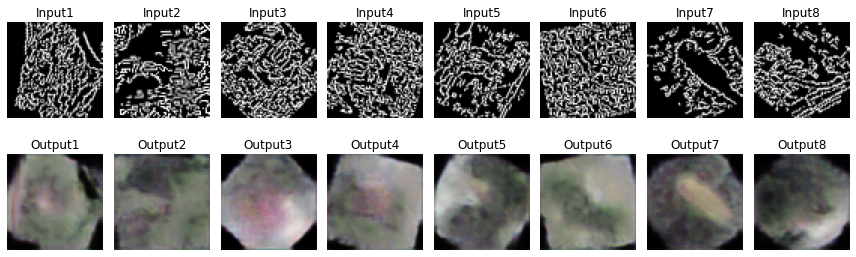

Iter:550, LossG:0.2412 (fake:0.0000, L1:0.2412), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:600, LossG:0.2029 (fake:0.0000, L1:0.2029), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter600.pt, D >> models/pix2pix_D_iter600.pt
Iter:650, LossG:0.1738 (fake:0.0000, L1:0.1738), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:700, LossG:0.1808 (fake:0.0000, L1:0.1808), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:750, LossG:0.1791 (fake:0.0000, L1:0.1791), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:800, LossG:0.1621 (fake:0.0000, L1:0.1621), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter800.pt, D >> models/pix2pix_D_iter800.pt
Iter:850, LossG:0.1889 (fake:0.0000, L1:0.1889), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:900, LossG:0.1790 (fake:0.0000, L1:0.1790), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:950, LossG:0.1491 (fake:0.0000, L1:0.1491), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1000, LossG:0.1774 (fake:0.0000, L1:0.1774), LossD

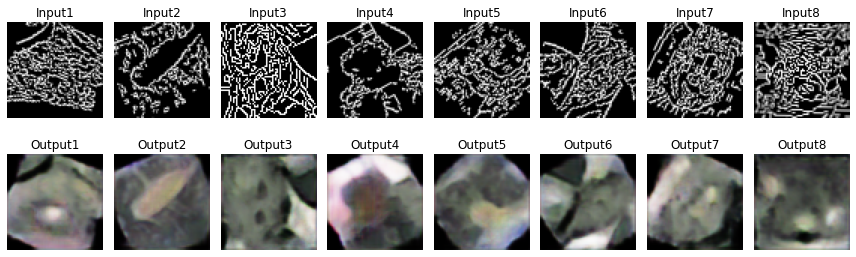

Iter:1050, LossG:0.1601 (fake:0.0000, L1:0.1601), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1100, LossG:0.1651 (fake:0.0000, L1:0.1651), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1150, LossG:0.1601 (fake:0.0000, L1:0.1601), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1200, LossG:0.1579 (fake:0.0000, L1:0.1579), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter1200.pt, D >> models/pix2pix_D_iter1200.pt
Iter:1250, LossG:0.1611 (fake:0.0000, L1:0.1611), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1300, LossG:0.1417 (fake:0.0000, L1:0.1417), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1350, LossG:0.1554 (fake:0.0000, L1:0.1554), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1400, LossG:0.1603 (fake:0.0000, L1:0.1603), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter1400.pt, D >> models/pix2pix_D_iter1400.pt
Iter:1450, LossG:0.1371 (fake:0.0000, L1:0.1371), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1500, LossG:0.1230 (fake:0.0000, L1:0

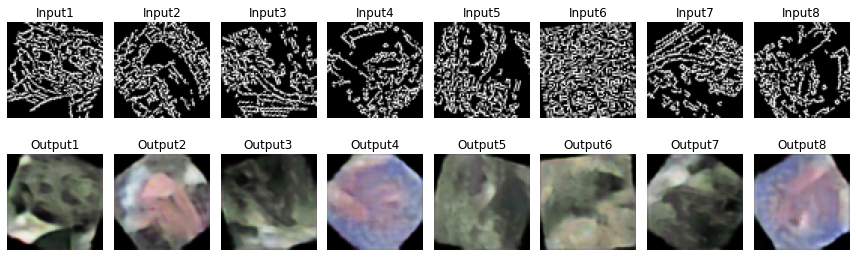

Iter:1550, LossG:0.1303 (fake:0.0000, L1:0.1303), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1600, LossG:0.1316 (fake:0.0000, L1:0.1316), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter1600.pt, D >> models/pix2pix_D_iter1600.pt
Iter:1650, LossG:0.1255 (fake:0.0000, L1:0.1255), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1700, LossG:0.1700 (fake:0.0000, L1:0.1700), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1750, LossG:0.1395 (fake:0.0000, L1:0.1395), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1800, LossG:0.1368 (fake:0.0000, L1:0.1368), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter1800.pt, D >> models/pix2pix_D_iter1800.pt
Iter:1850, LossG:0.1199 (fake:0.0000, L1:0.1199), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1900, LossG:0.1310 (fake:0.0000, L1:0.1310), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:1950, LossG:0.1201 (fake:0.0000, L1:0.1201), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2000, LossG:0.1143 (fake:0.0000, L1:0

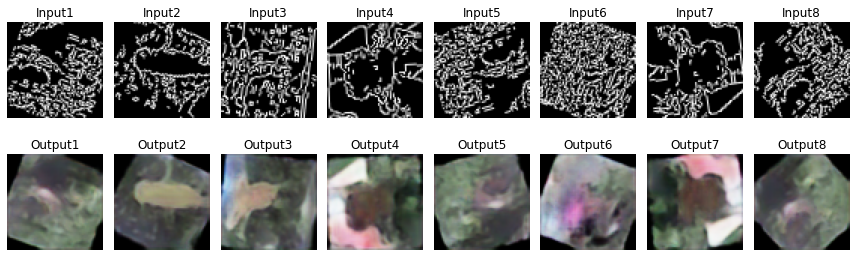

Iter:2050, LossG:0.1253 (fake:0.0000, L1:0.1253), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2100, LossG:0.1253 (fake:0.0000, L1:0.1253), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2150, LossG:0.1276 (fake:0.0000, L1:0.1276), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2200, LossG:0.1321 (fake:0.0000, L1:0.1321), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter2200.pt, D >> models/pix2pix_D_iter2200.pt
Iter:2250, LossG:0.1314 (fake:0.0000, L1:0.1314), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2300, LossG:0.1281 (fake:0.0000, L1:0.1281), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2350, LossG:0.1150 (fake:0.0000, L1:0.1150), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2400, LossG:0.1120 (fake:0.0000, L1:0.1120), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter2400.pt, D >> models/pix2pix_D_iter2400.pt
Iter:2450, LossG:0.1411 (fake:0.0000, L1:0.1411), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2500, LossG:0.1283 (fake:0.0000, L1:0

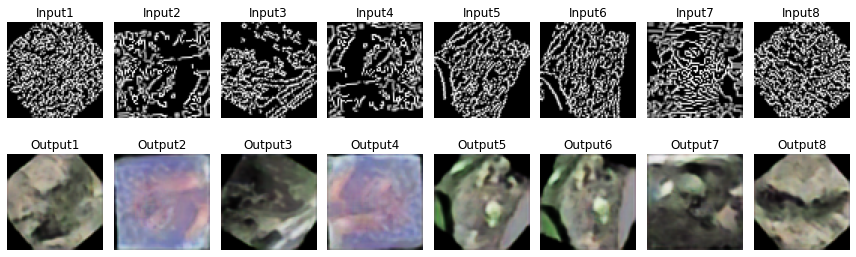

Iter:2550, LossG:0.1207 (fake:0.0000, L1:0.1207), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2600, LossG:0.1275 (fake:0.0000, L1:0.1275), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter2600.pt, D >> models/pix2pix_D_iter2600.pt
Iter:2650, LossG:0.1086 (fake:0.0000, L1:0.1086), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2700, LossG:0.1130 (fake:0.0000, L1:0.1130), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2750, LossG:0.1191 (fake:0.0000, L1:0.1191), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2800, LossG:0.1408 (fake:0.0000, L1:0.1408), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter2800.pt, D >> models/pix2pix_D_iter2800.pt
Iter:2850, LossG:0.1201 (fake:0.0000, L1:0.1201), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2900, LossG:0.1087 (fake:0.0000, L1:0.1087), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:2950, LossG:0.1197 (fake:0.0000, L1:0.1197), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3000, LossG:0.1013 (fake:0.0000, L1:0

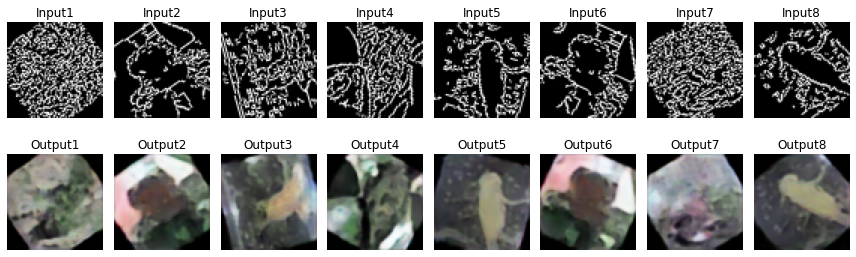

Iter:3050, LossG:0.1003 (fake:0.0000, L1:0.1003), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3100, LossG:0.1148 (fake:0.0000, L1:0.1148), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3150, LossG:0.1207 (fake:0.0000, L1:0.1207), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3200, LossG:0.1217 (fake:0.0000, L1:0.1217), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter3200.pt, D >> models/pix2pix_D_iter3200.pt
Iter:3250, LossG:0.1134 (fake:0.0000, L1:0.1134), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3300, LossG:0.1047 (fake:0.0000, L1:0.1047), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3350, LossG:0.1143 (fake:0.0000, L1:0.1143), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3400, LossG:0.1103 (fake:0.0000, L1:0.1103), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter3400.pt, D >> models/pix2pix_D_iter3400.pt
Iter:3450, LossG:0.1180 (fake:0.0000, L1:0.1180), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3500, LossG:0.1178 (fake:0.0000, L1:0

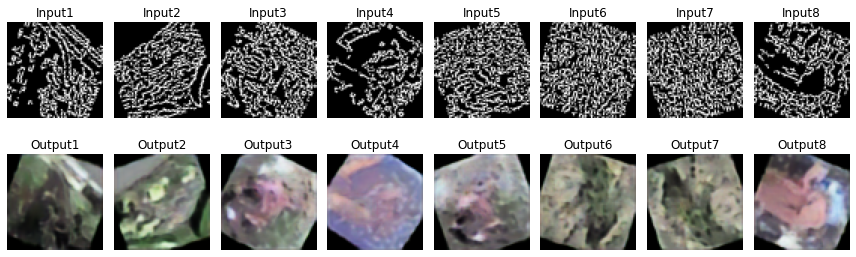

Iter:3550, LossG:0.0941 (fake:0.0000, L1:0.0941), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3600, LossG:0.1179 (fake:0.0000, L1:0.1179), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter3600.pt, D >> models/pix2pix_D_iter3600.pt
Iter:3650, LossG:0.1074 (fake:0.0000, L1:0.1074), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3700, LossG:0.1004 (fake:0.0000, L1:0.1004), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3750, LossG:0.1095 (fake:0.0000, L1:0.1095), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3800, LossG:0.1088 (fake:0.0000, L1:0.1088), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter3800.pt, D >> models/pix2pix_D_iter3800.pt
Iter:3850, LossG:0.1258 (fake:0.0000, L1:0.1258), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3900, LossG:0.1030 (fake:0.0000, L1:0.1030), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:3950, LossG:0.1156 (fake:0.0000, L1:0.1156), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4000, LossG:0.1126 (fake:0.0000, L1:0

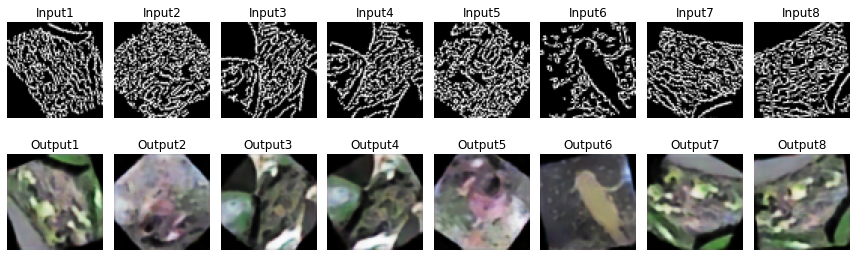

Iter:4050, LossG:0.1045 (fake:0.0000, L1:0.1045), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4100, LossG:0.1099 (fake:0.0000, L1:0.1099), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4150, LossG:0.1111 (fake:0.0000, L1:0.1111), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4200, LossG:0.1055 (fake:0.0000, L1:0.1055), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter4200.pt, D >> models/pix2pix_D_iter4200.pt
Iter:4250, LossG:0.0985 (fake:0.0000, L1:0.0985), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4300, LossG:0.1160 (fake:0.0000, L1:0.1160), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4350, LossG:0.1071 (fake:0.0000, L1:0.1071), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4400, LossG:0.0926 (fake:0.0000, L1:0.0926), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter4400.pt, D >> models/pix2pix_D_iter4400.pt
Iter:4450, LossG:0.1043 (fake:0.0000, L1:0.1043), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4500, LossG:0.1048 (fake:0.0000, L1:0

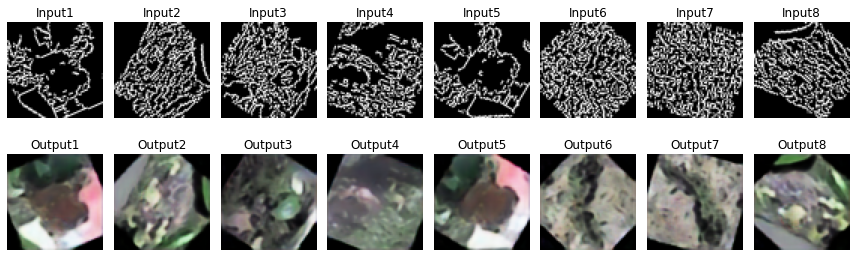

Iter:4550, LossG:0.0988 (fake:0.0000, L1:0.0988), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4600, LossG:0.1049 (fake:0.0000, L1:0.1049), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter4600.pt, D >> models/pix2pix_D_iter4600.pt
Iter:4650, LossG:0.1040 (fake:0.0000, L1:0.1040), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4700, LossG:0.0952 (fake:0.0000, L1:0.0952), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4750, LossG:0.1062 (fake:0.0000, L1:0.1062), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4800, LossG:0.1017 (fake:0.0000, L1:0.1017), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter4800.pt, D >> models/pix2pix_D_iter4800.pt
Iter:4850, LossG:0.1375 (fake:0.0000, L1:0.1375), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4900, LossG:0.1016 (fake:0.0000, L1:0.1016), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:4950, LossG:0.0970 (fake:0.0000, L1:0.0970), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5000, LossG:0.1029 (fake:0.0000, L1:0

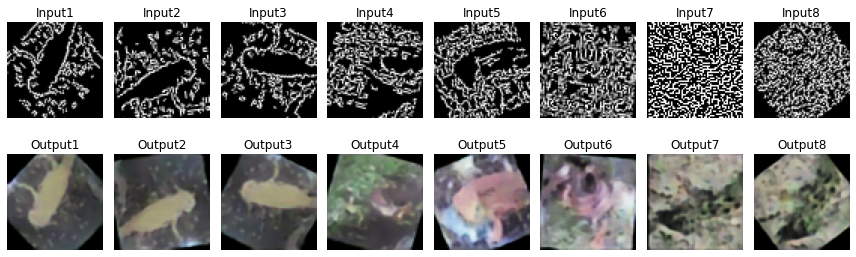

Iter:5050, LossG:0.0977 (fake:0.0000, L1:0.0977), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5100, LossG:0.0905 (fake:0.0000, L1:0.0905), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5150, LossG:0.0965 (fake:0.0000, L1:0.0965), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5200, LossG:0.1108 (fake:0.0000, L1:0.1108), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter5200.pt, D >> models/pix2pix_D_iter5200.pt
Iter:5250, LossG:0.1140 (fake:0.0000, L1:0.1140), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5300, LossG:0.0933 (fake:0.0000, L1:0.0933), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5350, LossG:0.1059 (fake:0.0000, L1:0.1059), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5400, LossG:0.1020 (fake:0.0000, L1:0.1020), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter5400.pt, D >> models/pix2pix_D_iter5400.pt
Iter:5450, LossG:0.1036 (fake:0.0000, L1:0.1036), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5500, LossG:0.0967 (fake:0.0000, L1:0

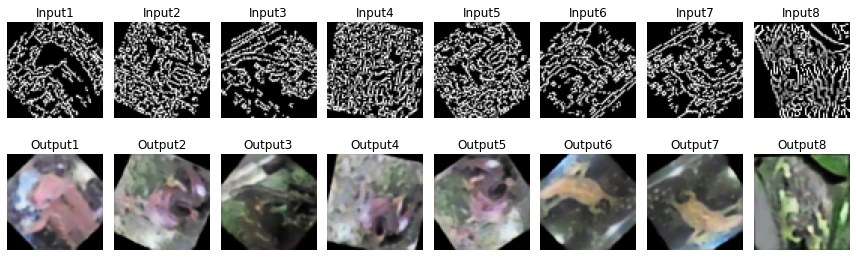

Iter:5550, LossG:0.1076 (fake:0.0000, L1:0.1076), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5600, LossG:0.1061 (fake:0.0000, L1:0.1061), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter5600.pt, D >> models/pix2pix_D_iter5600.pt
Iter:5650, LossG:0.1066 (fake:0.0000, L1:0.1066), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5700, LossG:0.0930 (fake:0.0000, L1:0.0930), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5750, LossG:0.1026 (fake:0.0000, L1:0.1026), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5800, LossG:0.1173 (fake:0.0000, L1:0.1173), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter5800.pt, D >> models/pix2pix_D_iter5800.pt
Iter:5850, LossG:0.0900 (fake:0.0000, L1:0.0900), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5900, LossG:0.0972 (fake:0.0000, L1:0.0972), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:5950, LossG:0.0950 (fake:0.0000, L1:0.0950), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6000, LossG:0.0911 (fake:0.0000, L1:0

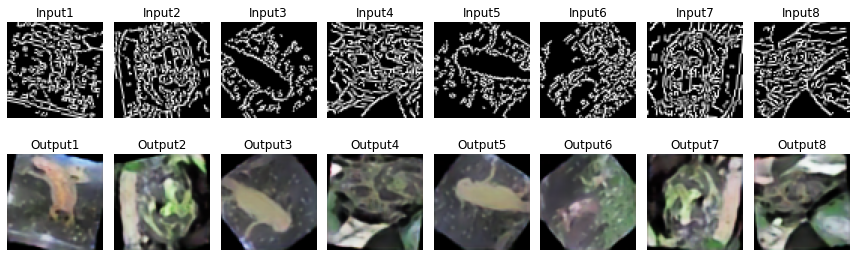

Iter:6050, LossG:0.1089 (fake:0.0000, L1:0.1089), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6100, LossG:0.0957 (fake:0.0000, L1:0.0957), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6150, LossG:0.0946 (fake:0.0000, L1:0.0946), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6200, LossG:0.0953 (fake:0.0000, L1:0.0953), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter6200.pt, D >> models/pix2pix_D_iter6200.pt
Iter:6250, LossG:0.0929 (fake:0.0000, L1:0.0929), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6300, LossG:0.1109 (fake:0.0000, L1:0.1109), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6350, LossG:0.0996 (fake:0.0000, L1:0.0996), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6400, LossG:0.1058 (fake:0.0000, L1:0.1058), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter6400.pt, D >> models/pix2pix_D_iter6400.pt
Iter:6450, LossG:0.1027 (fake:0.0000, L1:0.1027), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6500, LossG:0.0992 (fake:0.0000, L1:0

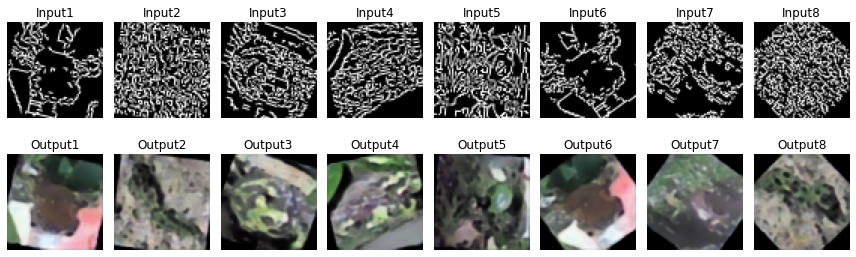

Iter:6550, LossG:0.1233 (fake:0.0000, L1:0.1233), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6600, LossG:0.0979 (fake:0.0000, L1:0.0979), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter6600.pt, D >> models/pix2pix_D_iter6600.pt
Iter:6650, LossG:0.0860 (fake:0.0000, L1:0.0860), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6700, LossG:0.0891 (fake:0.0000, L1:0.0891), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6750, LossG:0.0858 (fake:0.0000, L1:0.0858), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6800, LossG:0.0959 (fake:0.0000, L1:0.0959), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter6800.pt, D >> models/pix2pix_D_iter6800.pt
Iter:6850, LossG:0.1094 (fake:0.0000, L1:0.1094), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6900, LossG:0.0870 (fake:0.0000, L1:0.0870), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:6950, LossG:0.0982 (fake:0.0000, L1:0.0982), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7000, LossG:0.0892 (fake:0.0000, L1:0

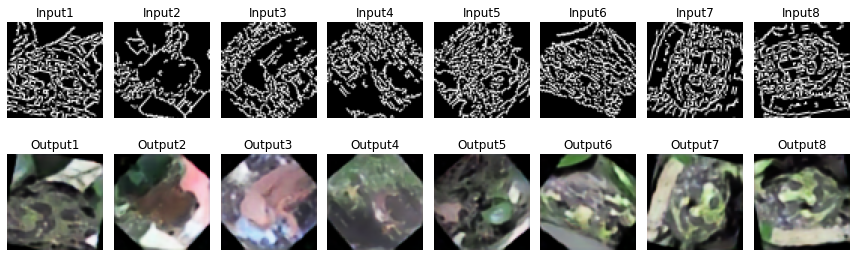

Iter:7050, LossG:0.0915 (fake:0.0000, L1:0.0915), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7100, LossG:0.1110 (fake:0.0000, L1:0.1110), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7150, LossG:0.0898 (fake:0.0000, L1:0.0898), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7200, LossG:0.0831 (fake:0.0000, L1:0.0831), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter7200.pt, D >> models/pix2pix_D_iter7200.pt
Iter:7250, LossG:0.0900 (fake:0.0000, L1:0.0900), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7300, LossG:0.0983 (fake:0.0000, L1:0.0983), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7350, LossG:0.0849 (fake:0.0000, L1:0.0849), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7400, LossG:0.0934 (fake:0.0000, L1:0.0934), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter7400.pt, D >> models/pix2pix_D_iter7400.pt
Iter:7450, LossG:0.0853 (fake:0.0000, L1:0.0853), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7500, LossG:0.0810 (fake:0.0000, L1:0

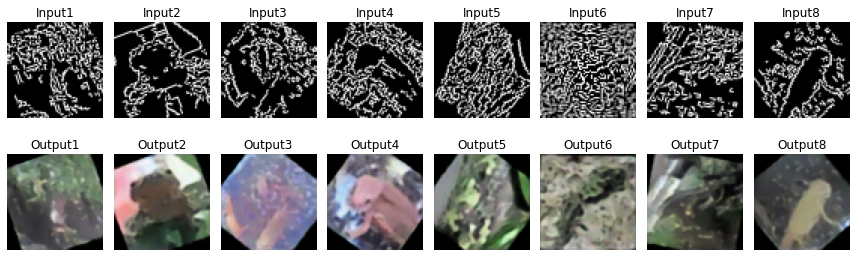

Iter:7550, LossG:0.0904 (fake:0.0000, L1:0.0904), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7600, LossG:0.0767 (fake:0.0000, L1:0.0767), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter7600.pt, D >> models/pix2pix_D_iter7600.pt
Iter:7650, LossG:0.1026 (fake:0.0000, L1:0.1026), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7700, LossG:0.0847 (fake:0.0000, L1:0.0847), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7750, LossG:0.0836 (fake:0.0000, L1:0.0836), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7800, LossG:0.0858 (fake:0.0000, L1:0.0858), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter7800.pt, D >> models/pix2pix_D_iter7800.pt
Iter:7850, LossG:0.0933 (fake:0.0000, L1:0.0933), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7900, LossG:0.0907 (fake:0.0000, L1:0.0907), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:7950, LossG:0.0925 (fake:0.0000, L1:0.0925), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8000, LossG:0.0903 (fake:0.0000, L1:0

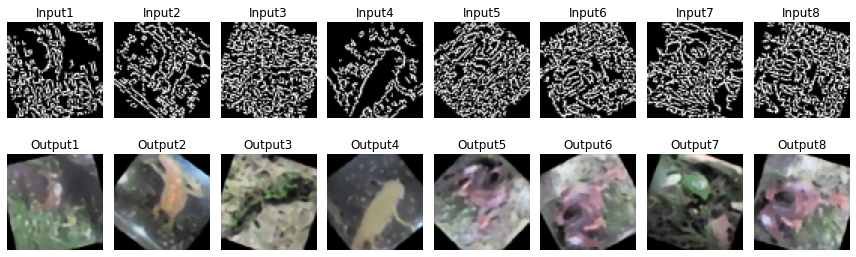

Iter:8050, LossG:0.0890 (fake:0.0000, L1:0.0890), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8100, LossG:0.0895 (fake:0.0000, L1:0.0895), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8150, LossG:0.0898 (fake:0.0000, L1:0.0898), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8200, LossG:0.0805 (fake:0.0000, L1:0.0805), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter8200.pt, D >> models/pix2pix_D_iter8200.pt
Iter:8250, LossG:0.0867 (fake:0.0000, L1:0.0867), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8300, LossG:0.0835 (fake:0.0000, L1:0.0835), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8350, LossG:0.0937 (fake:0.0000, L1:0.0937), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8400, LossG:0.0826 (fake:0.0000, L1:0.0826), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter8400.pt, D >> models/pix2pix_D_iter8400.pt
Iter:8450, LossG:0.0834 (fake:0.0000, L1:0.0834), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8500, LossG:0.0903 (fake:0.0000, L1:0

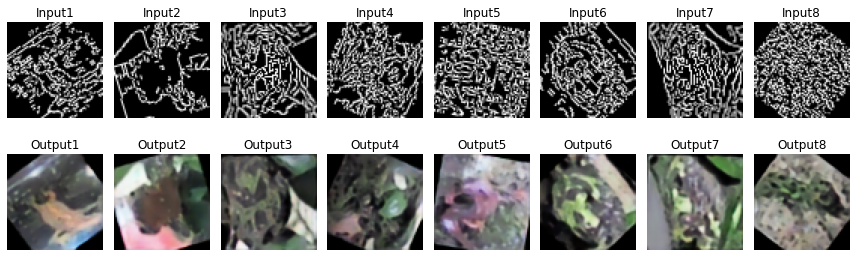

Iter:8550, LossG:0.1017 (fake:0.0000, L1:0.1017), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8600, LossG:0.0831 (fake:0.0000, L1:0.0831), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter8600.pt, D >> models/pix2pix_D_iter8600.pt
Iter:8650, LossG:0.0881 (fake:0.0000, L1:0.0881), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8700, LossG:0.0924 (fake:0.0000, L1:0.0924), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8750, LossG:0.0858 (fake:0.0000, L1:0.0858), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8800, LossG:0.0826 (fake:0.0000, L1:0.0826), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter8800.pt, D >> models/pix2pix_D_iter8800.pt
Iter:8850, LossG:0.0916 (fake:0.0000, L1:0.0916), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8900, LossG:0.0914 (fake:0.0000, L1:0.0914), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:8950, LossG:0.0854 (fake:0.0000, L1:0.0854), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9000, LossG:0.0934 (fake:0.0000, L1:0

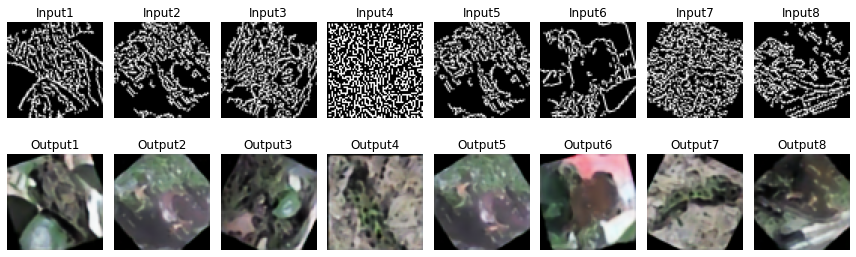

Iter:9050, LossG:0.0868 (fake:0.0000, L1:0.0868), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9100, LossG:0.0928 (fake:0.0000, L1:0.0928), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9150, LossG:0.0793 (fake:0.0000, L1:0.0793), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9200, LossG:0.0848 (fake:0.0000, L1:0.0848), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter9200.pt, D >> models/pix2pix_D_iter9200.pt
Iter:9250, LossG:0.0808 (fake:0.0000, L1:0.0808), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9300, LossG:0.0841 (fake:0.0000, L1:0.0841), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9350, LossG:0.0842 (fake:0.0000, L1:0.0842), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9400, LossG:0.0891 (fake:0.0000, L1:0.0891), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter9400.pt, D >> models/pix2pix_D_iter9400.pt
Iter:9450, LossG:0.0907 (fake:0.0000, L1:0.0907), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9500, LossG:0.0872 (fake:0.0000, L1:0

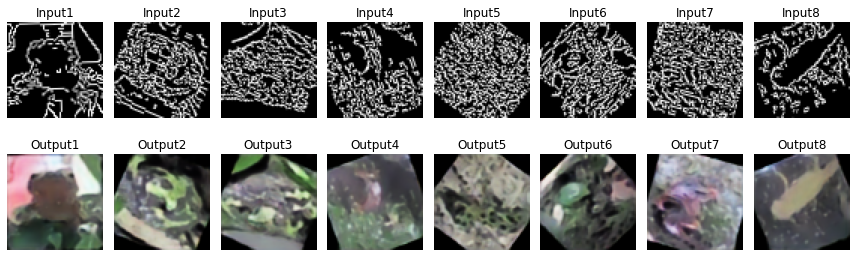

Iter:9550, LossG:0.0896 (fake:0.0000, L1:0.0896), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9600, LossG:0.0846 (fake:0.0000, L1:0.0846), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter9600.pt, D >> models/pix2pix_D_iter9600.pt
Iter:9650, LossG:0.0820 (fake:0.0000, L1:0.0820), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9700, LossG:0.0730 (fake:0.0000, L1:0.0730), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9750, LossG:0.0828 (fake:0.0000, L1:0.0828), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9800, LossG:0.0924 (fake:0.0000, L1:0.0924), LossD:0.0000 (real:0.0000, fake:0.0000)
save G >> models/pix2pix_G_iter9800.pt, D >> models/pix2pix_D_iter9800.pt
Iter:9850, LossG:0.0790 (fake:0.0000, L1:0.0790), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9900, LossG:0.0926 (fake:0.0000, L1:0.0926), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:9950, LossG:0.0783 (fake:0.0000, L1:0.0783), LossD:0.0000 (real:0.0000, fake:0.0000)
Iter:10000, LossG:0.0816 (fake:0.0000, L1:

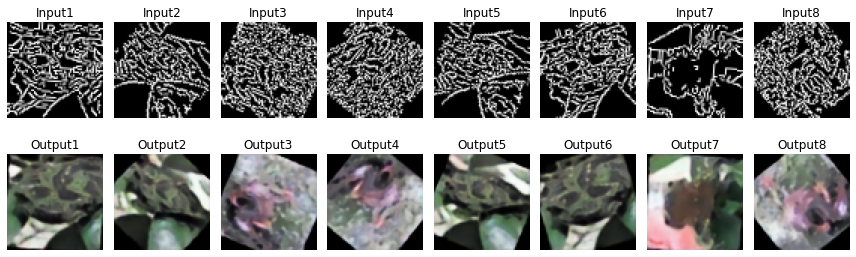

final paramters were saved to G >> models/pix2pix_G_final.pt, D >> models/pix2pix_D_final.pt
loss was saved to >> result/pix2pix_loss.txt


In [9]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    summary(G,(cfg.INPUT_CHANNEL, cfg.INPUT_HEIGHT, cfg.INPUT_WIDTH), device=cfg.DEVICE_TYPE)
    summary(D,(cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH), device=cfg.DEVICE_TYPE)
    
    G.apply(weights_init)
    D.apply(weights_init)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']
    
    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_G_fake= []
    list_loss_G_l1 = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []

    ones = torch.zeros([cfg.TRAIN.MINIBATCH, 1], dtype=torch.float).to(cfg.DEVICE)
    zeros = ones * 0
    
    loss_bce = torch.nn.BCELoss(reduction='mean')
    loss_l1 = torch.nn.L1Loss(reduction='mean')

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        opt_D.zero_grad()

        # sample X
        Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)
        ys = torch.tensor(get_image(paths[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

        # forward
        Gz = G(Xs)
        loss_D_fake = loss_bce(D(Gz), ones)# + loss_bce(D(Xs), ones)
        loss_D_real = loss_bce(D(ys), zeros)# + loss_bce(D(Xs), zeros)
        
        # loss backward
        loss_D = loss_D_fake + loss_D_real
        loss_D.backward(retain_graph=True)

        opt_D.step()
            

        # update G
        opt_G.zero_grad()
        loss_G_fake = loss_bce(D(Gz), zeros)# + loss_bce(D(Xs), zeros) # fake loss
        loss_G_l1 = cfg.PIX2PIX_LAMBDA * loss_l1(Gz, ys) # L1 loss
        loss_G = loss_G_fake + loss_G_l1
        loss_G.backward()
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_G_fake = loss_G_fake.item()
        _loss_G_l1 = loss_G_l1.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_G_fake.append(_loss_G_fake)
                list_loss_G_l1.append(_loss_G_l1)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG:{:.4f} (fake:{:.4f}, L1:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f})'.format(
                i + 1, _loss_G, _loss_G_fake, _loss_G_l1, _loss_D, _loss_D_real, _loss_D_fake))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, Xs, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_G_fake' : list_loss_G_fake,
                           'loss_G_l1' : list_loss_G_l1, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

100%|██████████| 6/6 [00:00<00:00, 1397.71it/s]

--------------------
test function
--------------------
Dataset >> /content/drive/My Drive/Colab Notebooks/Dataset/test/images/
 - Found data num >> 6
 - Horizontal >> False
 - Vertical >> False
 - Rotation >> False
all data num >> 6
dataset was completely loaded
--


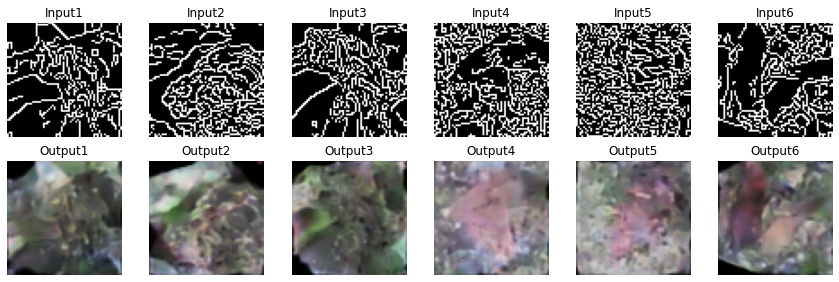

In [20]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    path_dict = data_load(cfg, train=False, hf=False, vf=False, rot=False)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']
    
    Test_Num = min(len(paths), cfg.TEST.MAX_SAMPLES)
    
    np.random.seed(0)
    
    with torch.no_grad():
        for i in range(0, Test_Num, cfg.TEST.MINIBATCH):
            test_inds = np.arange(i, min(i + cfg.TEST.MINIBATCH, Test_Num))
            path = paths[test_inds]
            Xs = get_image(path, cfg, mode=cfg.INPUT_MODE)
            Xs = torch.tensor(Xs, dtype=torch.float).to(cfg.DEVICE)
           
            result_show(G, Xs, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), 
                        save=cfg.TEST.RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)
test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
